<a href="https://colab.research.google.com/github/FuturisticLover123/labs/blob/main/lab10/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [923]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

In [924]:
x, y  = make_classification(n_samples=100, n_features=2, n_redundant=0, n_classes=4, n_clusters_per_class=1, random_state=23, class_sep=3)

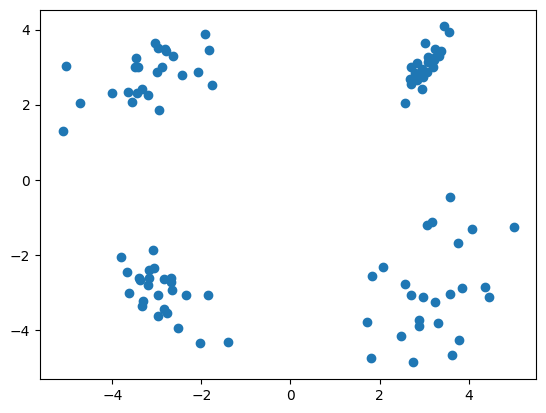

In [925]:
plt.scatter(x[:,0], x[:,1])

In [926]:
#task 1

In [927]:
class KMeans:
  def __init__(self, k=3, max_iter=100):
    self.labels_, self.k= list(range(k)), k
    self.max_iter=max_iter

  def _init_one_center(self, x):
    return np.array([np.random.uniform(np.min(x[:, i]) , np.max(x[: , i])) for i in range(x.shape[1])])

  def _init_centers(self, x):
    return np.array([self._init_one_center(x) for _ in self.labels_])

  def fit(self, x):
    self.cluster_centers_ = self._init_centers(x)
    for n in range(self.max_iter):
      new_clusters = self.kmeans_step(x)
      if np.array_equal(new_clusters, self.cluster_centers_):
        return self
      self.cluster_centers_ = new_clusters
    return self


  def kmeans_step(self, x):
    clusters = [list() for _ in self.labels_]
    for point in x:
      distances = [np.linalg.norm(point - center) for center in self.cluster_centers_]
      clusters[np.argmin(distances)].append(point)

    new_centers = np.array([np.mean(cluster,axis=0) if len(cluster) > 0 else self._init_one_center(x) for cluster in clusters])
    return new_centers

  def classify(self, x):
    return np.argmin([np.linalg.norm(x - center) for center in self.cluster_centers_])

  def predict(self, x):
    return np.array([self.classify(x_i) for x_i in x])






In [928]:
def picture(y_out, centers, labels, ax):
  colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
  ax.clear()

  for color, m in zip(colors, labels):
    points = x[np.where(y_out == m)[0], :]
    ax.scatter(points[:, 0], points[:, 1], c=color)
    ax.scatter(*centers[m] , c='red', s=100)

    circle = plt.Circle(centers[m], max([np.linalg.norm(point - centers[m]) for point in points]), color=color, fill=False)
    ax.add_artist(circle)


In [929]:

class KMeansAnimation(KMeans):
  def __init__(self, k=3, max_iter=100):
    self.labels_, self.k= list(range(k)), k
    self.max_iter=max_iter
    self.fitting_data = list()
    self.fitting_outs = list()


  def fit(self, x):
    self.cluster_centers_ = self._init_centers(x)

    self.fitting_data.append(self.cluster_centers_.copy())
    self.fitting_outs.append(self.predict(x).copy())

    for n in range(self.max_iter):
      new_clusters = self.kmeans_step(x)
      if np.array_equal(new_clusters, self.cluster_centers_):
        self.fitting_data.append(self.cluster_centers_.copy())
        self.fitting_outs.append(self.predict(x).copy())
        return self

      self.cluster_centers_ = new_clusters

      self.fitting_data.append(self.cluster_centers_.copy())
      self.fitting_outs.append(self.predict(x).copy())
    return self


In [930]:
class SuperInitKMeans(KMeans):
  def __init__(self, k=3, n_steps=5, n_models=5):
    super().__init__(k=k)

    self.n_steps, self.n_models =n_steps, n_models

  def _init_centers(self, x):
    for _ in range(self.n_models):
      return np.mean([KMeans(k=self.k, max_iter=self.n_steps).fit(x).cluster_centers_ for _ in range(self.n_models)], axis=0)


<ipython-input-928-da56e0d3eabb>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], c=color)


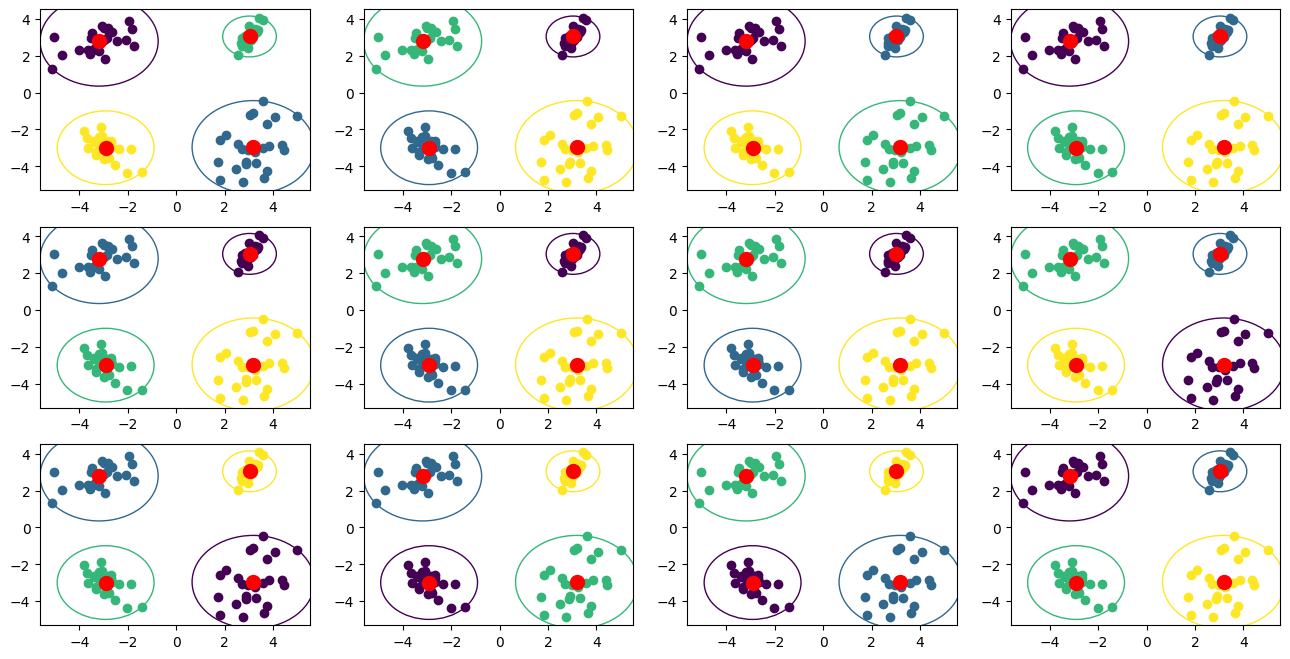

In [931]:
fig, axes = plt.subplots(3, 4, figsize=(16, 8))
for ax, _ in zip(axes.ravel(), range(12)):
    model = SuperInitKMeans(k=4, n_steps=2, n_models=5).fit(x)
    picture(model.predict(x), model.cluster_centers_, model.labels_, ax)

<ipython-input-928-da56e0d3eabb>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], c=color)


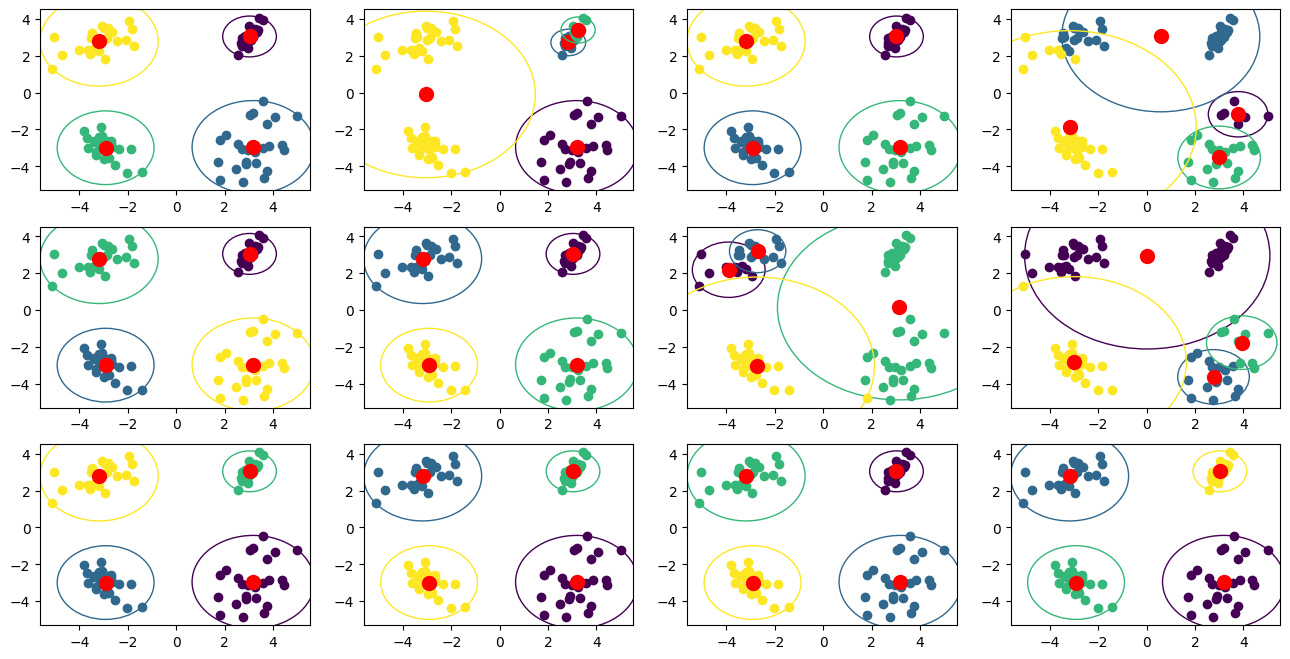

In [932]:
fig, axes = plt.subplots(3, 4, figsize=(16, 8))
for ax, _ in zip(axes.ravel(), range(12)):
    model = SuperInitKMeans(k=4, n_steps=10, n_models=15).fit(x)
    picture(model.predict(x), model.cluster_centers_, model.labels_, ax)

In [ ]:
kmani = KMeansAnimation(k=4).fit(x)
fit_centers, fit_clusters = kmani.fitting_data, kmani.fitting_outs

<ipython-input-283-e8eb00ab4a7e>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], c=color)


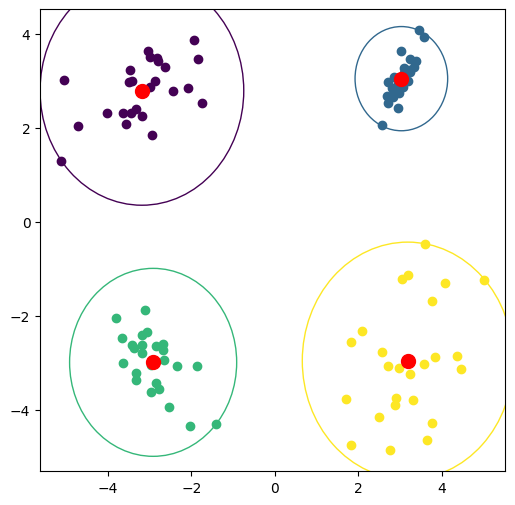

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
picture(fit_clusters[-1], fit_centers[-1], kmani.labels_, ax);

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def update(frame):
    picture(fit_clusters[frame], fit_centers[frame], kmani.labels_, ax);



ani = FuncAnimation(fig, update, frames=len(fit_centers)-1, interval=1000, repeat=False);

display(HTML(ani.to_jshtml()))

<ipython-input-283-e8eb00ab4a7e>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], c=color)


In [ ]:
# dbscan

In [933]:
# ШаРоВыЕ ДеРеВьЯ
# прикольная структура данных
# нужна для быстрого поиска точек в окрестности заданной точки
class BallTree:
  def __init__(self, points):
    self.root = self.Node(points)

  def get_neibours(self, point, r):
    return np.array(self.root.get_neibours(point, r))

  class Node:
    def __init__(self, points):
      self.c = points.mean(axis=0)
      distances = [np.linalg.norm(self.c - p) for p in points]

      self.r = max(distances)
      fpoint = points[np.argmax(distances)]
      indexes = np.array([np.linalg.norm(fpoint - p) > self.r for p in points])
      right = points[indexes]
      left = points[~indexes]

      if left.shape[0] == 1:
        self.left = BallTree.Leaf(left)
      else:
        self.left = BallTree.Node(left)

      if right.shape[0] == 1:
        self.right = BallTree.Leaf(right)
      else:
        self.right = BallTree.Node(right)

    def get_neibours(self, point, r):
      d = np.linalg.norm(point - self.c)
      if d > self.r + r:
        return []
      else:
         return self.left.get_neibours(point, r) + self.right.get_neibours(point, r)

  class Leaf:
    def __init__(self, point):
      self.point = point[0]

    def get_neibours(self, point, r):
      d = np.linalg.norm(point - self.point)
      if d > r:
        return []
      else:
         return [self.point]


In [934]:
points = np.array([[1,1],[2,2], [3,1],[5,5], [6,6]])
bt = BallTree(points)

In [935]:
bt.get_neibours(np.array([1, 1]), 2)

array([[1, 1],
       [2, 2],
       [3, 1]])

In [936]:
from collections import deque

class DBScan:
  def __init__(self, k=2, eps = 1):
    self.k, self.eps = k, eps
    self.balltree = None
    # анимашка
    self.fitting_data = list()

  def fit(self, points):
    self.clusters_ = list()
    if self.balltree is None:
      self.balltree = BallTree(points)

    visited = set()
    dq = deque(points)
    noise = set(tuple(point) for point in points)

    while dq:
      point = dq.pop()
      if tuple(point) in visited:
        continue

      neibours = self.balltree.get_neibours(point, self.eps)

      if neibours.shape[0] - 1 >= self.k:
        cluster = self.form_cluster(point, neibours)
        visited.update(cluster)
        self.clusters_.append(np.array(list(cluster)))
        noise.difference_update(cluster)
        continue

      visited.add(tuple(point))

    self.labels_ = np.arange(0, len(self.clusters_))
    self.noise_ = np.array(list(noise))

    return self

  def form_cluster(self, point, neibours):
    cluster = {tuple(point)}
    dq = deque(neibours)

    #нужно для анимашки
    self.fitting_data.extend([(_, "new_cluster"),(point, "active_point"),(point, "radius"),(neibours, "neibours")])


    while dq:
      point = dq.pop()
      if tuple(point) in cluster:
        continue

      #нужно для анимашки
      self.fitting_data.extend([(point, "active_point"),(point, "radius"),(neibours, "neibours")])


      cluster.add(tuple(point))

      neibours = self.balltree.get_neibours(point, self.eps)
      if neibours.shape[0] - 1 >= self.k:
        dq.extend(neibours)

      #нужно для анимашки
      self.fitting_data.append((_, "end_cluster"))

    return cluster


In [937]:
def DBScanPicture(clusters, labels, noise, ax):
  colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
  ax.clear()

  for color, points, label in zip(colors, clusters, labels):
    ax.scatter(points[:, 0], points[:, 1], c=color)

  if noise.shape[0]:
    ax.scatter(noise[:, 0],  noise[:, 1], c='red', s=2)


In [938]:
k = [1, 3, 7]
eps = [0.5, 1, 2, 7]
model = DBScan().fit(x)

<ipython-input-937-fd93abcf0af4>:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], c=color)


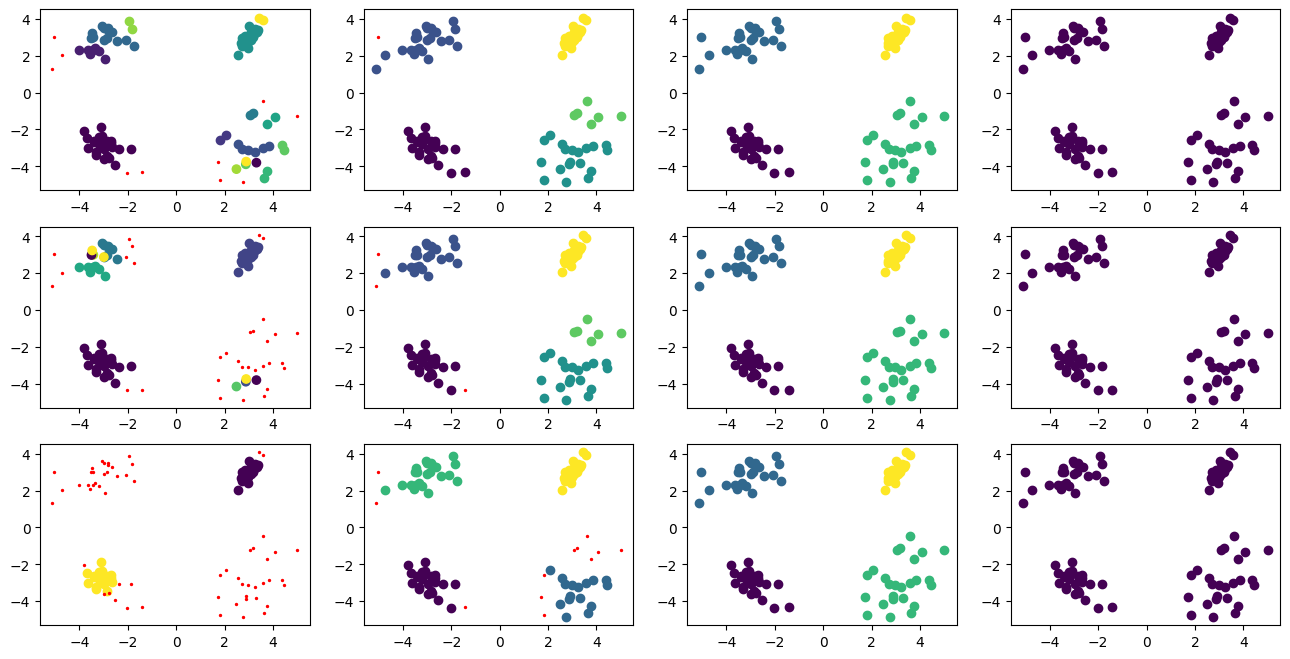

In [939]:
import itertools
fig, axes = plt.subplots(3, 4, figsize=(16, 8))
for ax, params in zip(axes.ravel(), list(itertools.product(k, eps))):
    model.k, model.eps = params
    model.fit(x)
    clusters, labels, noise = model.clusters_, model.labels_, model.noise_
    DBScanPicture(clusters, labels, noise, ax)

In [1008]:
db = DBScan(k=1, eps = 2).fit(points)
model = DBScan(k=1, eps=2).fit(x)

In [1009]:
import matplotlib.patches as patches

class Animation:
  def __init__(self, fitting_data, points, eps):
    self.points = points
    self.fitting_data = fitting_data.copy()
    self.fig, self.ax = plt.subplots(figsize=(6, 6))
    self.init_picture()
    self.colors = deque(["yellow", "blue", "red", "purple"])
    self.color = None
    self.circle = None
    self.eps=eps
    self.ax.set_xlim(min(points[:, 0]) - 1, max(points[:, 0]) + 1)
    self.ax.set_ylim(min(points[:, 1]) - 1, max(points[:, 1]) + 1)

  #


  def init_picture(self):
    self.ax.scatter(self.points[:, 0], self.points[:, 1], c="black", s=1)

  def update(self, frame):
    point, event = self.fitting_data[frame]
    if event == "active_point":
      self.ax.scatter(*point, c="orange", s=20)
      if self.circle is not None:
        self.circle.remove()

    elif event == "radius":
      self.circle = patches.Circle(point, self.eps, edgecolor=self.color, facecolor='none')
      self.ax.add_patch(self.circle)

    elif event == "new_cluster":
      self.color = self.colors.pop()

    elif event == "neibours":
      self.ax.scatter(point[:, 0], point[:, 1], c=self.color, s=20)

    elif event == "end_cluster":
      pass

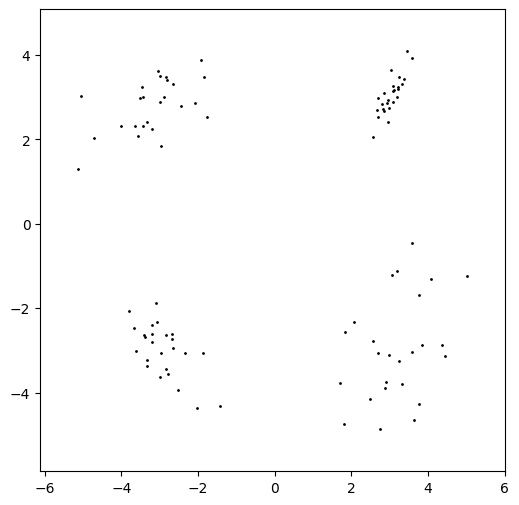

In [1010]:
a = Animation(model.fitting_data, x, model.eps)

In [1011]:
ani =FuncAnimation(a.fig, a.update, frames=len(a.fitting_data), interval=300, repeat=False)

In [ ]:
HTML(ani.to_jshtml())

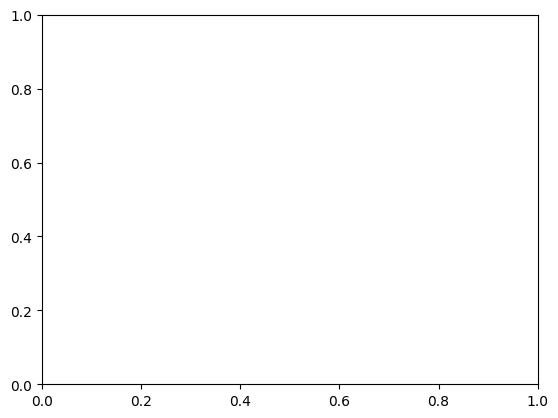

In [997]:
fig, ax = plt.subplots()

In [ ]:
ax.